[*********************100%***********************]  1 of 1 completed


The spot price is £ Ticker
BARC.L    257.15
Name: 2024-11-22 00:00:00, dtype: float64
The annualised volatility is Ticker
BARC.L    28.29
dtype: float64 %


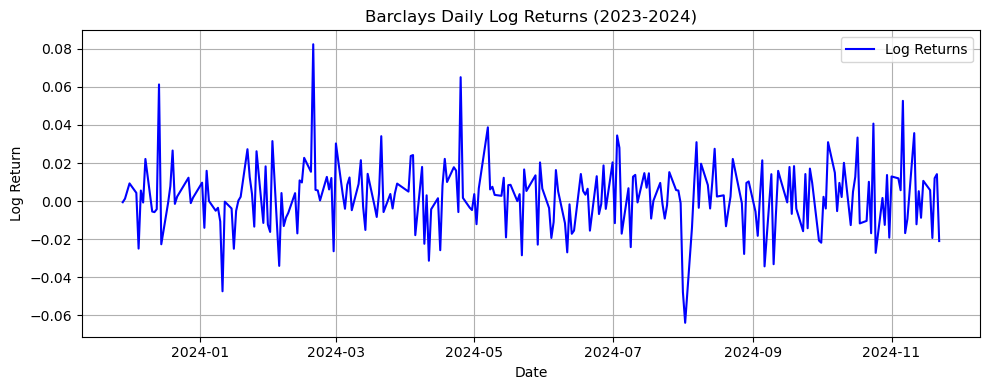

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Download Barclays data (LSE ticker: BARC.L)
BARC = yf.download("BARC.L", start="2023-11-25", end="2024-11-25")

# Spot price
S = BARC['Close'].iloc[-1]
print('The spot price is £', round(S, 2))

# Log returns
log_return = np.log(BARC['Close'] / BARC['Close'].shift(1))

# Historical volatility (annualised)
vol_h = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol_h * 100, 2), '%')

# Optional: plot log returns
plt.figure(figsize=(10, 4))
plt.plot(log_return, label="Log Returns", color='blue')
plt.title('Barclays Daily Log Returns (2023-2024)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
import numpy as np
import pandas as pd
import scipy.stats as si
import yfinance as yf
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")  # clean output

# Newton-Raphson Function
def newton_vol_call(S, K, T, C, r):
    MAX_ITERATIONS = 1000
    tolerance = 0.000001
    sigma = 0.25

    for i in range(MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
        vega = S * np.sqrt(T) * si.norm.pdf(d1)

        diff = C - price
        if abs(diff) < tolerance:
            return sigma
        sigma += diff / vega

    return sigma

# Download JPM spot price
jpm_df = yf.download("JPM", start="2024-04-01", end="2024-04-05")
jpm_price = jpm_df['Close'].tail(1).values[0]

# Get options for a valid expiration date
JPM = yf.Ticker("JPM")
print("Available expirations:", JPM.options)
chosen_expiry = '2025-05-02'  # pick from available ones
opt_chain = JPM.option_chain(chosen_expiry)
calls = opt_chain.calls

# Clean up the DataFrame to show the essentials
columns_to_show = ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility']
calls_display = calls[columns_to_show].copy()
calls_display = calls_display.reset_index(drop=True)

# Display like the image
# Display the calls DataFrame like a table
print(calls_display.to_string(index=False))



[*********************100%***********************]  1 of 1 completed


Available expirations: ('2025-04-11', '2025-04-17', '2025-04-25', '2025-05-02', '2025-05-09', '2025-05-16', '2025-05-23', '2025-06-20', '2025-07-18', '2025-08-15', '2025-09-19', '2025-10-17', '2025-12-19', '2026-01-16', '2026-03-20', '2026-06-18', '2026-12-18', '2027-01-15', '2027-12-17')
    contractSymbol             lastTradeDate  strike  lastPrice   bid   ask     change  percentChange  volume  openInterest  impliedVolatility
JPM250502C00145000 2025-04-03 19:51:41+00:00   145.0      84.00 68.50 72.70   0.000000       0.000000     NaN             0           0.946290
JPM250502C00150000 2025-04-04 19:10:05+00:00   150.0      62.93 64.85 67.90   0.000000       0.000000    10.0            10           0.992432
JPM250502C00200000 2025-04-04 16:38:36+00:00   200.0      21.75 22.25 22.90   1.240000       6.045830     3.0             3           0.644718
JPM250502C00205000 2025-04-07 18:52:11+00:00   205.0      18.80 18.80 19.40 -10.400002     -35.616440    29.0             1           0.62

In [57]:
print(calls['strike'].unique())


[145. 150. 200. 205. 210. 215. 220. 225. 230. 235. 240. 245. 250. 255.
 260. 265. 270. 275. 280. 285. 290. 295. 300. 315.]


In [63]:
# Choose a valid strike (check from calls['strike'].unique())
K = 200.0

# Filter the row
option_row = calls[calls.strike == K]
if option_row.empty:
    raise ValueError(f"No call option found for strike {K}")

# Use lastPrice if available, else fallback to midpoint
C_raw = option_row['lastPrice'].values[0]
if pd.isna(C_raw) or C_raw == 0.0:
    bid = option_row['bid'].values[0]
    ask = option_row['ask'].values[0]
    C = float((bid + ask) / 2)
    print(f"Using midpoint of bid-ask: {C:.2f}")
else:
    C = float(C_raw)

# Estimate time to maturity
expiry = datetime.strptime(chosen_expiry, "%Y-%m-%d")
today = datetime.today()
T = (expiry - today).days / 365
S = jpm_price
r = 0.035

# Estimate IV
impvol = newton_vol_call(S, K, T, C, r)
print(f"The implied volatility is {round(float(impvol) * 100, 2)}% for JPM call option with strike ${K}")



The implied volatility is 132.0% for JPM call option with strike $200.0


In [1]:
import numpy as np
import pandas as pd
import scipy.stats as si
import yfinance as yf
from datetime import datetime

In [17]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import scipy.stats as si
import yfinance as yf
from datetime import datetime

# Step 2: Define the Newton-Raphson function for implied volatility
def newton_vol_call(S, K, T, C, r):
    MAX_ITERATIONS = 1000
    tolerance = 0.000001
    sigma = 0.25  # initial guess

    for i in range(MAX_ITERATIONS):
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        # BSM formula for European PUT option
        price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
        vega = S * np.sqrt(T) * si.norm.pdf(d1)

        diff = C - price
        if abs(diff) < tolerance:
            return sigma
        sigma += diff / vega

    return sigma

# Step 3: Get Tesla’s current spot price
tesla_df = yf.download("TSLA", start="2024-04-01", end="2024-04-08")
S = float(tesla_df['Close'].tail(1).values[0])  # Use 'Close' and ensure it's a float
print(f"Spot price (S) = ${S:.2f}")

# Step 4: Retrieve Tesla's put options for expiry June 20, 2025
TESLA = yf.Ticker("TSLA")
puts = TESLA.option_chain('2025-06-20').puts

# Step 5: Set parameters for the specific put option
K = 150.0  # strike price
r = 0.05   # 5% risk-free rate
expiry = datetime.strptime("2025-06-20", "%Y-%m-%d")
today = datetime.today()
T = (expiry - today).days / 365  # time to maturity in years

# Step 6: Get the market price of the put option at strike K
try:
    put_price = float(puts.lastPrice[puts.strike == K].iloc[0])
    if put_price == 0.0 or pd.isna(put_price):
        raise ValueError
except:
    bid = float(puts.bid[puts.strike == K].iloc[0])
    ask = float(puts.ask[puts.strike == K].iloc[0])
    put_price = (bid + ask) / 2
    print(f"Using bid-ask midpoint: ${put_price:.2f}")

print(f"Put option price (P) = ${put_price:.2f}")
print(f"Strike (K) = ${K}, T = {T:.4f} years, r = {r:.2%}")

# Step 7: Estimate implied volatility
implied_vol = newton_vol_call(S, K, T, put_price, r)
print(f"Implied Volatility (σ) = {round(implied_vol * 100, 2)}%")


[*********************100%***********************]  1 of 1 completed
C:\Users\sola_\AppData\Local\Temp\ipykernel_8404\3729449894.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(tesla_df['Close'].tail(1).values[0])  # Use 'Close' and ensure it's a float


Spot price (S) = $164.90
Put option price (P) = $5.10
Strike (K) = $150.0, T = 0.1973 years, r = 5.00%
Implied Volatility (σ) = 41.42%


In [45]:
# Step 1: Import libraries
import numpy as np
import pandas as pd
import scipy.stats as si
import yfinance as yf
from datetime import datetime

# Step 2: Newton-Raphson function with higher initial guess
def newton_vol_call(S, K, T, C, r):
    MAX_ITERATIONS = 1000
    tolerance = 0.000001
    sigma = 0.25

    for i in range(MAX_ITERATIONS):
        try:
            d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
            d2 = d1 - sigma * np.sqrt(T)

            # Black-Scholes formula for European PUT option
            price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
            vega = S * np.sqrt(T) * si.norm.pdf(d1)

            diff = C - price
            if abs(diff) < tolerance:
                return sigma

            if vega < 1e-8:
                return np.nan  # Vega too small, avoid instability

            sigma += diff / vega
        except:
            return np.nan

    return np.nan

# Step 3: Download Tesla spot price
tesla_df = yf.download("TSLA", start="2024-04-01", end="2024-04-08")
S = float(tesla_df['Close'].tail(1).values[0])
print(f"Spot price (S) = ${S:.2f}")

# Step 4: Get put option data for expiry
TESLA = yf.Ticker("TSLA")
puts = TESLA.option_chain('2025-06-20').puts

# Step 5: Set input parameters
K = 350.0
r = 0.05
expiry = datetime.strptime("2025-06-20", "%Y-%m-%d")
today = datetime.today()
T = (expiry - today).days / 365

# Step 6: Get market price of the $350 put option
try:
    put_price = float(puts.lastPrice[puts.strike == K].iloc[0])
    if put_price == 0.0 or pd.isna(put_price):
        raise ValueError
except:
    bid = float(puts.bid[puts.strike == K].iloc[0])
    ask = float(puts.ask[puts.strike == K].iloc[0])
    put_price = (bid + ask) / 2
    print(f"Using bid-ask midpoint: ${put_price:.2f}")

print(f"Put option price (P) = ${put_price:.2f}")
print(f"Strike (K) = ${K}, T = {T:.4f} years, r = {r:.2%}")

# Step 7: Estimate implied volatility
implied_vol = newton_vol_call(S, K, T, put_price, r)

# Step 8: Display result
if np.isnan(implied_vol):
    print(f"⚠️ Implied Volatility could not be reliably calculated for strike ${K}.")
else:
    print(f"Implied Volatility (σ) = {round(implied_vol * 100, 2)}%")


[*********************100%***********************]  1 of 1 completed
C:\Users\sola_\AppData\Local\Temp\ipykernel_8404\3061832060.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  S = float(tesla_df['Close'].tail(1).values[0])


Spot price (S) = $164.90
Put option price (P) = $111.50
Strike (K) = $350.0, T = 0.1973 years, r = 5.00%
⚠️ Implied Volatility could not be reliably calculated for strike $350.0.


In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Download past 1 year of Tesla stock prices
tesla_hist = yf.download("TSLA", start="2023-04-08", end="2024-04-08")
tesla_hist = tesla_hist['Close']

# Step 2: Compute daily log returns
log_returns = np.log(tesla_hist / tesla_hist.shift(1)).dropna()

# Step 3: Calculate standard deviation of daily returns
daily_vol = log_returns.std()

# Step 4: Annualize the volatility
hist_vol_annual = daily_vol * np.sqrt(252)
print(f"📊 Annualized Historical Volatility = {round(hist_vol_annual * 100, 2)}%")




[*********************100%***********************]  1 of 1 completed

📊 Annualized Historical Volatility = Ticker
TSLA    47.93
dtype: float64%
